# Data Preprocessing

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.pandas.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv(r'dataset/EasyVisa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
df.shape

(25480, 12)

## Data cleaning

* Handling missing values
* Handling duplicate values
* Check datatype of columns

### 1.1 Check Null values

In [5]:
df.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

**NO null values present**

### 1.2 Check for duplicate records

In [6]:
df.duplicated().sum()

0

**NO record is duplicated**

In [7]:
# Removeing case_id as it refer to unique id
df.drop(columns=['case_id'],inplace =True)

## Feature Engineering

### Feature Extraction

In [8]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [9]:
# using yr_of_estab we can find how old employer's company is
from  datetime import date

today_date = date.today()
current_year = today_date.year
current_year

2025

In [10]:
df['company_age'] = current_year - df['yr_of_estab'] 
df['company_age']

0         18
1         23
2         17
3        128
4         20
        ... 
25475     17
25476     19
25477    115
25478    138
25479     65
Name: company_age, Length: 25480, dtype: int64

In [11]:
# now we can drop yr_of_estab ,as company_age convey same information
df.drop(columns=['yr_of_estab'],inplace =True)

### Type of Features

##### Numerical Features

In [12]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
numerical_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [13]:
# contineous feature
contineous_features = [feature for feature in numerical_features if len(df[feature].value_counts()) > 25]
descrete_features = [feature for feature in numerical_features if len(df[feature].value_counts()) <= 25]
print(f'contineous_features : {contineous_features}')
print(f'descrete_features : {descrete_features}')

contineous_features : ['no_of_employees', 'prevailing_wage', 'company_age']
descrete_features : []


#### Categorical Features

In [14]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
categorical_features

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status']

## Split dataset into X(Independet features),y(dependent features)

In [15]:
X = df.drop(columns=['case_status'])
y= df['case_status']
X.shape,y.shape

((25480, 10), (25480,))

#### Manually encoding `case_status`

In [16]:
y.value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

In [17]:
# Denied->1 ,certified -> 0
y = np.where(y=='Denied',1,0)

In [18]:
y

array([1, 0, 1, ..., 0, 0, 0])

## Feature Transformation

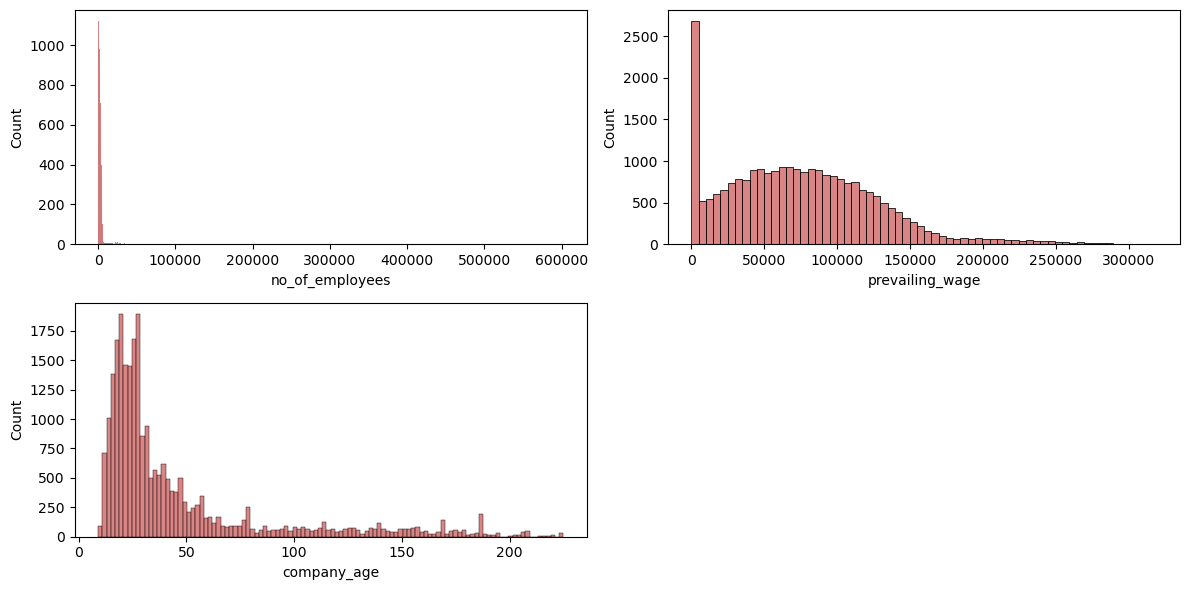

In [19]:
plt.figure(figsize=(12,6))
for i, col in enumerate(numerical_features):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X[col],color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* No of employees and Copmany age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

**Checking Skewness**

What is skewness : Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero

In [20]:
X[contineous_features].skew(axis = 0 ,skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

* Positiviely Skewed : company_age, no_of_employees.
* We can handle outliers and then check the skewness.

## Apply Power Transformer to Check if it can reduces the outliers¶

In [21]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method ='yeo-johnson')
transform_features = ['company_age','no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [22]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)

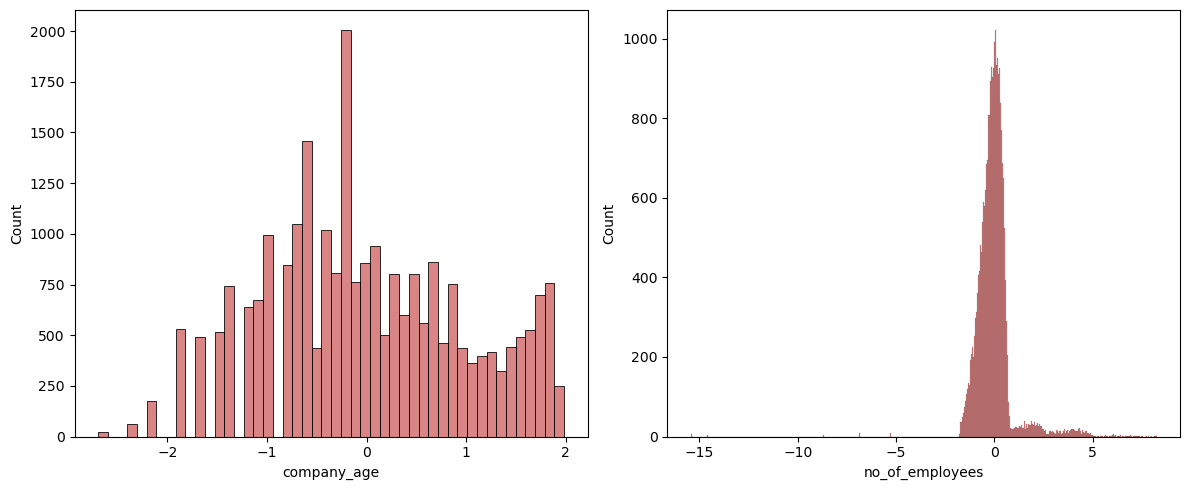

In [25]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

**Checking Skewness**

In [26]:
X_copy.skew(axis=0, skipna=True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

* Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
* So Power Transformer with yeo-johnson can be used.

In [28]:
for feature in categorical_features:
    print(feature,':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories** 
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler** 
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.